In [131]:
import numpy as np
import cvxpy as cp
import Custom_Layers
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as st

from tensorflow.keras.models import load_model
from CustomModels_cvxpylayer import SimpleModel as SimpleModelCvxpyLayer
from CustomModels_cvxmin import SimpleModel as SimpleModelCvxMin
from CustomModels import SimpleModel as SimpleModelBase

# Parameters 

In [132]:
n_days = 12000
n_stocks = 5
window_in = 80 
window_out = 80

# Data creation

# asset indépendant

In [133]:
Mat_return = []

var = np.random.randint(1, 10, size=n_stocks)
std = np.sqrt(var)
return_rd = np.empty((n_stocks, n_days))
for i in range(n_stocks):
    return_rd[i, :] = np.random.normal(0, std[i], size=n_days)

Sigma_true = np.diag(var)

Mat_return=return_rd


In [134]:
import numpy as np
import pandas as pd

# Volatilité journalière cible (par actif)
vol_target = np.array([0.05, 0.03, 0.02, 0.015, 0.01])
p = 0.5
nb_periodes = 1000

# 1️⃣ Calcul de n correspondant à la vol souhaitée
n_values = (p * (1 - p)) / (vol_target ** 2)
n_values = np.round(n_values).astype(int)  # n doit être un entier

print("n choisis pour chaque actif :", n_values)

# 2️⃣ Simulation des rendements centrés
X = np.array([np.random.binomial(n, p, nb_periodes) for n in n_values])
Rendements = (X - n_values[:, None] * p) / n_values[:, None]

# 3️⃣ Vérification de la vol réelle
vol_empirique = Rendements.std(axis=1)

# 4️⃣ Mise en DataFrame
df_rendements = pd.DataFrame(
    Rendements.T,
    columns=[f"Actif_{i+1}" for i in range(len(n_values))]
)

print("\nVolatilité cible :", vol_target)
print("Volatilité empirique :", np.round(vol_empirique, 4))

n choisis pour chaque actif : [ 100  278  625 1111 2500]

Volatilité cible : [0.05  0.03  0.02  0.015 0.01 ]
Volatilité empirique : [0.0498 0.0302 0.0204 0.0152 0.0098]


### modélisation par gaussienne corrélés 

In [135]:
rng = np.random.default_rng(42)
def random_sigma(n_days=4000, n_stocks=10):
    """
    Génère directement des rendements corrélés à partir d'une loi normale multivariée.
    """
    
    
    # Volatilités annuelles (10% à 40%)
    vol_daily = rng.uniform(0.10, 0.40, n_stocks)
    
    # Conversion en volatilité journalière
    vol_annual = vol_daily * np.sqrt(252)
    
   
    df = np.random.randint( n_stocks + 2 , 10*n_stocks)
    R = st.invwishart.rvs( df = df , scale = np.eye(n_stocks))*(df-n_stocks-1)

    # Matrice de covariance
    sigma = np.outer(vol_daily, vol_daily) * R
    
    return sigma, R

In [136]:
sigma, R = random_sigma(n_days=n_days, n_stocks=n_stocks)
mu=np.zeros(n_stocks)
def generate_correlated_returns(n_days, n_stocks, sigma ,method):
    """
    Génère directement des rendements corrélés à partir d'une loi normale multivariée.
    """
    
    # Volatilités annuelles (10% à 40%)
    vol_daily = rng.uniform(0.10, 0.40, n_stocks)
    
    # Conversion en volatilité journalière
    vol_annual = vol_daily * np.sqrt(252)
    
    if method=='normal':
        Mat_return=st.multivariate_normal.rvs(mean=mu, cov=sigma, size=n_days)
    elif method=='t':
        Mat_return=st.multivariate_t.rvs(loc=mu, shape=sigma, df=5, size=n_days)
    return Mat_return

Mat_return = generate_correlated_returns(n_days=n_days, n_stocks=n_stocks, sigma=sigma, method='t').transpose()



In [137]:

# === DÉCOUPAGE TRAIN/TEST (80/20) ===
split_idx = 8 * n_days // 10
print(f"Split index: {split_idx}")

Mat_return_train = Mat_return[:, :split_idx]
Mat_return_test = Mat_return[:, split_idx:]

# Calculer les matrices de covariance
Mat_sigmatrue_train = np.cov(Mat_return_train)
Mat_sigmatrue_test = np.cov(Mat_return_test)

# === VÉRIFICATIONS ===
print("=== SHAPES ===")
print(f"Mat_return shape: {Mat_return.shape}")
print(f"Mat_return_train shape: {Mat_return_train.shape}")
print(f"Mat_return_test shape: {Mat_return_test.shape}")

print("\n=== MATRICES DE COVARIANCE ===")
print(f"Sigma_true shape: {sigma.shape}")
print(f"Mat_sigmatrue_train shape: {Mat_sigmatrue_train.shape}")
print(f"Mat_sigmatrue_test shape: {Mat_sigmatrue_test.shape}")

print("\n=== CORRÉLATIONS ===")
Corr_empirique = np.corrcoef(Mat_return)
corr_offdiag = Corr_empirique[np.triu_indices(n_stocks, k=1)]

print(f"Ecart de Corrélations (moyenne): {np.mean(np.abs(R[np.triu_indices(n_stocks, k=1)]-corr_offdiag)):.3f}")
print("matrice de corrélation empirique:", Corr_empirique)



Split index: 9600
=== SHAPES ===
Mat_return shape: (5, 12000)
Mat_return_train shape: (5, 9600)
Mat_return_test shape: (5, 2400)

=== MATRICES DE COVARIANCE ===
Sigma_true shape: (5, 5)
Mat_sigmatrue_train shape: (5, 5)
Mat_sigmatrue_test shape: (5, 5)

=== CORRÉLATIONS ===
Ecart de Corrélations (moyenne): 0.031
matrice de corrélation empirique: [[ 1.          0.22290851 -0.33923826 -0.39843255  0.42999004]
 [ 0.22290851  1.          0.12026443  0.12694573  0.14479256]
 [-0.33923826  0.12026443  1.          0.16913316 -0.10745158]
 [-0.39843255  0.12694573  0.16913316  1.         -0.05739218]
 [ 0.42999004  0.14479256 -0.10745158 -0.05739218  1.        ]]


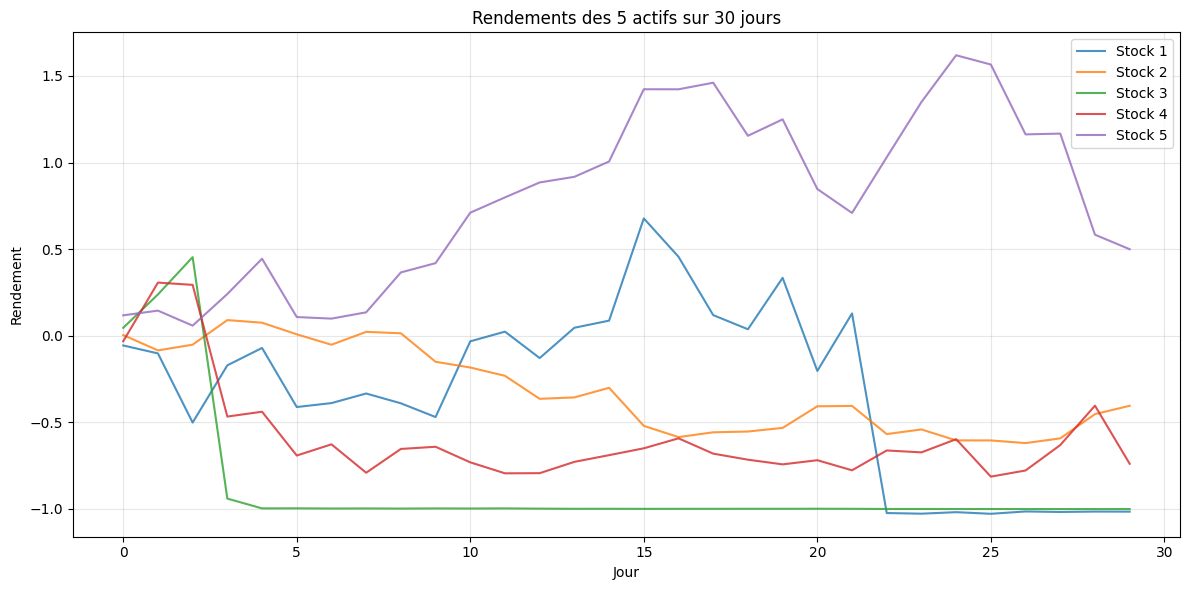

In [138]:


# Maintenant découper les 30 premiers jours
Mat_return_subset = Mat_return[:, :30]  # Shape: (10, 30) ✅

# Visualiser
plt.figure(figsize=(12, 6))
for i in range(n_stocks):
    cumret = (1+Mat_return_subset[i]).cumprod(axis=0) - 1
    plt.plot(np.arange(30), cumret, label=f'Stock {i+1}', alpha=0.8)

plt.title(f"Rendements des {n_stocks} actifs sur 30 jours")
plt.xlabel("Jour")
plt.ylabel("Rendement")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Creation des matrices d'entrainements

In [139]:
window_total = window_in + window_out
n_train_days = Mat_return_train.shape[1]
n_windows = (n_train_days - window_total) + 1

X_in_list = []
Sigma_out_list = []

for i in range(n_windows):
    # In-sample: 30 jours (input du réseau)
    X_in = Mat_return_train[:, i:i+window_in]  # (5, 30)
    
    # Out-sample: 10 jours (pour calculer la target)
    X_out = Mat_return_train[:, i+window_in:i+window_total]  # (5, 10) 
    
    # Target: 
    Sigma_out = np.cov(X_out)  # (5, 5) # essaie plage plus grande voir sigma true
    
    X_in_list.append(X_in)
    Sigma_out_list.append(Sigma_out)

# Convertir en arrays
X_in_array = np.array(X_in_list)       
Sigma_out_array = np.array(Sigma_out_list) 

print(f"X_in_array.shape: {X_in_array.shape}")
print(f"Sigma_out_array.shape: {Sigma_out_array.shape}")

X_in_array.shape: (9441, 5, 80)
Sigma_out_array.shape: (9441, 5, 5)


In [140]:
def data_generator(X_in_list, Sigma_out_list, batch_size):
    n_samples = len(X_in_list)
    indices = np.arange(n_samples)
    
    while True:
        np.random.shuffle(indices)
        
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            batch_indices = indices[start_idx:end_idx]
            
            X_batch = np.array([X_in_list[i] for i in batch_indices])
            Sigma_batch = np.array([Sigma_out_list[i] for i in batch_indices])
            
            yield X_batch, Sigma_batch

### Creation des matrices de test

In [141]:
# Paramètres des fenêtres (mêmes que pour train)
window_total = window_in + window_out

# === Créer les fenêtres de TEST ===
n_test_days = Mat_return_test.shape[1]  # 600
n_test_windows = (n_test_days - window_total) + 1

Y_in_list = []
Sigma_out_test_list = []


for i in range(n_test_windows):
    # In-sample: 30 jours (input pour la prédiction)
    Y_in = Mat_return_test[:, i:i+window_in]  # (5, 30)
    
    # Out-sample: 10 jours suivants
    Y_out = Mat_return_test[:, i+window_in:i+window_total]  # (5, 10)
    
    # Target: matrice de covariance vraie (sans bruit)
    Sigma_out_test = np.cov(Y_out)  # (5, 5)
    
    Y_in_list.append(Y_in)
    Sigma_out_test_list.append(Sigma_out_test)

# Convertir en arrays
Y_in_array = np.array(Y_in_list)  # (561, 5, 30)
Sigma_out_test_array = np.array(Sigma_out_test_list)  # (561, 5, 5)

print(f"Y_in_array.shape: {Y_in_array.shape}")
print(f"Sigma_out_test_array.shape: {Sigma_out_test_array.shape}")

Y_in_array.shape: (2241, 5, 80)
Sigma_out_test_array.shape: (2241, 5, 5)


# Useful functions 

In [142]:
def poids_min_variance(A):
    """
    Calcule les poids du portefeuille de variance minimale 
    """
    ones = np.ones(A.shape[0])
    A_inv = np.linalg.inv(A)

    w = A_inv @ ones
    w /= ones @ A_inv @ ones
    
    return w

In [143]:
def minimise_variance_lo(sigma: np.ndarray) -> np.ndarray:
    """
    Résout un problème de portefeuille à variance minimale.
    minimise   wᵀ Σ w
    s.c.       1ᵀ w = 1
               w ≥ 0           (sauf si allow_short_selling=True)
    Parameters
    -------
    np.ndarray
        Les poids optimaux du portefeuille minimisant la variance.
    """
    sigma = np.asarray(sigma)
    if sigma.ndim != 2 or sigma.shape[0] != sigma.shape[1]:
        raise ValueError("sigma doit être une matrice carrée.")
    
    # Vérifier si la matrice est symétrique
    if not np.allclose(sigma, sigma.T):
        raise ValueError("sigma doit être une matrice symétrique.")
    
    n_assets = sigma.shape[0]
    w = cp.Variable(n_assets)
    objective = cp.Minimize(cp.quad_form(w, sigma))
    constraints = [cp.sum(w) == 1]
    constraints.append(w >= 0)
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    if problem.status not in {cp.OPTIMAL, cp.OPTIMAL_INACCURATE}:
        raise RuntimeError(f"Optimisation échouée (status={problem.status}).")
    
    return w.value


# Training 

In [144]:
# parameter

batch_size = 64
n_epochs = 3
step_per_epoch =  len(X_in_array) // batch_size
gen = data_generator(X_in_list, Sigma_out_list, batch_size)

### Entrainement du NN 

In [ ]:
model = SimpleModelBase(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["weights"],
)
cov_model = SimpleModelBase(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["TransformedCovarianceMatrix"],
)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=Custom_Layers.variance_loss_function, run_eagerly=True)
cov_model.run_eagerly = True

print("=== Architecture du modèle NN seul ===")
print(model.summary())  # Enlever .backbone
print("\n=== Entraînement du modèle ===")

history = model.fit(gen, epochs=n_epochs, verbose=1,steps_per_epoch=step_per_epoch)
model.save_weights("simpleModelBase.weights.h5")
model.save("simpleModelBase.keras")
# cov_model.save("cov_model_base_correlated")

=== Architecture du modèle NN seul ===


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SampleSTD           │ [(None, None, 1), │          0 │ input_layer_40[0… │
│ (StandardDeviation… │ (None, None, 1)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_40         │ (None, None,      │          0 │ input_layer_40[0… │
│ (Subtract)          │ None)             │            │ SampleSTD[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_40      │ (None, None,      │          0 │ subtract_40[0][0… │
│ (TrueDivide)        │ None)             │            │ SampleSTD[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SampleCov           │ (None, None,      │          0 │ true_divide_40[0… │
│ (CovarianceLayer)   │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SpectralCov         │ [(None, None, 1), │          0 │ SampleCov[0][0]   │
│ (SpectralDecomposi… │ (None, None,      │            │                   │
│                     │ None)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DimensionAware      │ (None, None, 4)   │          0 │ SpectralCov[0][0… │
│ (DimensionAwareLay… │                   │            │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EigenvalueTransfor… │ (None, None)      │      2,145 │ DimensionAware[0… │
│ (DeepRecurrentLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STDTansformation    │ (None, None, 1)   │         25 │ SampleSTD[0][0]   │
│ (DeepLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TransformedCorrCom… │ (None, None,      │          0 │ EigenvalueTransf… │
│ (EigenProductLayer) │ None)             │            │ SpectralCov[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AddTransformedSTD   │ (None, None,      │          0 │ STDTansformation… │
│ (CovarianceLayer)   │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_40         │ (None, None,      │          0 │ TransformedCorrC… │
│ (Multiply)          │ None)             │            │ AddTransformedST… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PtfWeights          │ (None, None, 1)   │          0 │ multiply_40[0][0] │
│ (NormalizedSum)     │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,170 (8.48 KB)

 Trainable params: 2,170 (8.48 KB)

 Non-trainable params: 0 (0.00 B)

None

=== Entraînement du modèle ===
Epoch 1/3
  4/147 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 0.0226

### Entrainement du NN cvxpy layer

In [ ]:
model_cvxpylayer = SimpleModelCvxpyLayer(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["weights"],
)
cov_model_cvxpylayer = SimpleModelCvxpyLayer(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["TransformedCovarianceMatrix"],
)

model_cvxpylayer.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=Custom_Layers.variance_loss_function, run_eagerly=True)
cov_model_cvxpylayer.run_eagerly = True

try:
    model_cvxpylayer.backbone.load_weights("simple.weights.h5")
    print("✓ Poids chargés avec succès")
except Exception as e:
    print(f"⚠ Impossible de charger les poids: {e}")
    print("  Entraînement sans poids pré-chargés")


history = model_cvxpylayer.fit(gen, epochs=n_epochs, verbose=1,steps_per_epoch=step_per_epoch)
model_cvxpylayer.save("model_cvxpylayer_correlated.keras")
# cov_model_cvxpylayer.save("cov_model_cvxpylayer_correlated")


# Pour le modèle CVXPY :




✓ Poids chargés avec succès
Epoch 1/3


/Users/orphee/Library/Python/3.12/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - loss: 0.0028

/Users/orphee/Library/Python/3.12/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 994ms/step - loss: 0.0031
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 831ms/step - loss: 0.0029
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 135s 916ms/step - loss: 0.0029


/Users/orphee/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


### Entrainement du NN avec cvxp sur output

In [ ]:
# Test du SimpleModel basé sur minimise_variance (version CVXPy classique)
model_cvxp_output = SimpleModelCvxMin(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["weights"],
)
cov_model_cvxp_output = SimpleModelCvxMin(
    n_days=n_days,
    n_assets=n_stocks,
    normalize_std='sum',
    lag_transform=False,
    hidden_layer_sizes=[8],
    recurrent_layer_sizes=[16],
    outputs=["TransformedCovarianceMatrix"],
)

cov_model_cvxp_output.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=Custom_Layers.frobenius_loss_function,
    run_eagerly=True,
)

print(model_cvxp_output.summary())
#print("model_cvxmin - covariance branch")
# cov_cvxmin = train_model.predict(X, verbose=0)
# print("Transformed covariance shape:", cov_cvxmin.shape)
history_min = cov_model_cvxp_output.fit(gen, epochs=n_epochs, verbose=2,steps_per_epoch=step_per_epoch)

model_cvxp_output.save("model_cvxmin_correlated.keras")
# cov_model_cvxp_output.save("cov_model_cvxmin_correlated")


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SampleSTD           │ [(None, None, 1), │          0 │ input_layer_38[0… │
│ (StandardDeviation… │ (None, None, 1)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_38         │ (None, None,      │          0 │ input_layer_38[0… │
│ (Subtract)          │ None)             │            │ SampleSTD[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_38      │ (None, None,      │          0 │ subtract_38[0][0… │
│ (TrueDivide)        │ None)             │            │ SampleSTD[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SampleCov           │ (None, None,      │          0 │ true_divide_38[0… │
│ (CovarianceLayer)   │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SpectralCov         │ [(None, None, 1), │          0 │ SampleCov[0][0]   │
│ (SpectralDecomposi… │ (None, None,      │            │                   │
│                     │ None)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DimensionAware      │ (None, None, 4)   │          0 │ SpectralCov[0][0… │
│ (DimensionAwareLay… │                   │            │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EigenvalueTransfor… │ (None, None)      │      2,145 │ DimensionAware[0… │
│ (DeepRecurrentLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STDTansformation    │ (None, None, 1)   │         25 │ SampleSTD[0][0]   │
│ (DeepLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TransformedCorrCom… │ (None, None,      │          0 │ EigenvalueTransf… │
│ (EigenProductLayer) │ None)             │            │ SpectralCov[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AddTransformedSTD   │ (None, None,      │          0 │ STDTansformation… │
│ (CovarianceLayer)   │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_38         │ (None, None,      │          0 │ TransformedCorrC… │
│ (Multiply)          │ None)             │            │ AddTransformedST… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PtfWeights          │ (None, 5, 1)      │          0 │ multiply_38[0][0] │
│ (MinVarianceWeight… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,170 (8.48 KB)

 Trainable params: 2,170 (8.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
147/147 - 42s - 288ms/step - loss: 0.1276
Epoch 2/3
147/147 - 36s - 247ms/step - loss: 0.0380
Epoch 3/3
147/147 - 42s - 286ms/step - loss: 0.0126


# Load NN

In [ ]:
# model_cvxpylayer = load_model("model_cvxpylayer_correlated", custom_objects={"SimpleModel": SimpleModelCvxpyLayer, "variance_loss_function": Custom_Layers.variance_loss_function})
# cov_model_cvxpylayer = load_model("cov_model_cvxpylayer_correlated", custom_objects={"SimpleModel": SimpleModelCvxpyLayer, "variance_loss_function": Custom_Layers.variance_loss_function})
# model = load_model("model_base_correlated", custom_objects={"SimpleModel": SimpleModelBase, "variance_loss_function": Custom_Layers.variance_loss_function})
# cov_model = load_model("cov_model_base_correlated", custom_objects={"SimpleModel": SimpleModelBase, "variance_loss_function": Custom_Layers.variance_loss_function})
# model_cvxp_output = load_model("model_cvxmin_correlated", custom_objects={"SimpleModel": SimpleModelCvxMin, "frobenius_loss_function": Custom_Layers.frobenius_loss_function})
# cov_model_cvxp_output = load_model("cov_model_cvxmin_correlated", custom_objects={"SimpleModel": SimpleModelCvxMin, "frobenius_loss_function": Custom_Layers.frobenius_loss_function})


# Test

### Test NN_cvxpy_layer vs NN

In [ ]:
import numpy as np

n_samples = Y_in_array.shape[0]  # 731

# === PRÉDICTIONS DES DEUX MODÈLES ===
print("Prédiction en batch pour les 2 modèles...")

# Modèle 1 : NN + CVXPyLayer 
print("\n1. NN + CVXPyLayer")
weights_cvxpylayer_all = model_cvxpylayer.predict(Y_in_array, verbose=1, batch_size=32)

# Modèle 2 : NN seul (sans contrainte long-only)
print("\n2. NN seul")
weights_nn_all = model.predict(Y_in_array, verbose=1, batch_size=32)

print(f"\nweights_cvxpylayer_all.shape: {weights_cvxpylayer_all.shape}")
print(f"weights_nn_all.shape: {weights_nn_all.shape}")

# === CALCUL DES VARIANCES ===
NN_cvxpylayer_std = np.empty(n_samples)
NN_std = np.empty(n_samples)
real_std = np.empty(n_samples)

weights_cvxpylayer_list = np.empty((n_samples, n_stocks))
weights_nn_list = np.empty((n_samples, n_stocks))
weights_real_list = np.empty((n_samples, n_stocks))

for i in range(n_samples):
    # Poids prédits par NN + CVXPyLayer
    weights_cvxpylayer = np.squeeze(weights_cvxpylayer_all[i])
    
    # Poids prédits par NN seul
    weights_nn = np.squeeze(weights_nn_all[i])
    
    # Poids optimaux (oracle)
    weights_real = poids_min_variance(Sigma_out_test_array[i])
    weights_real = np.squeeze(weights_real)
    
    # Stocker les poids
    weights_cvxpylayer_list[i] = weights_cvxpylayer
    weights_nn_list[i] = weights_nn
    weights_real_list[i] = weights_real
    
    # Calculer les variances réalisées (out-of-sample)
    NN_cvxpylayer_std[i] = weights_cvxpylayer.T @ Sigma_out_test_array[i] @ weights_cvxpylayer
    NN_std[i] = weights_nn.T @ Sigma_out_test_array[i] @ weights_nn
    real_std[i] = weights_real.T @ Sigma_out_test_array[i] @ weights_real

# === RÉSULTATS ===
print(f"\n{'='*60}")
print("RÉSULTATS")
print(f"{'='*60}")

print(f"\nNN_cvxpylayer_std.shape: {NN_cvxpylayer_std.shape}")
print(f"NN_std.shape: {NN_std.shape}")
print(f"real_std.shape: {real_std.shape}")

print(f"\nVariance moyenne NN + CVXPyLayer: {np.mean(NN_cvxpylayer_std):.6f}")
print(f"Variance moyenne NN seul: {np.mean(NN_std):.6f}")
print(f"Variance moyenne Réelle (Optimal): {np.mean(real_std):.6f}")

nb_negatifs = np.sum(weights_nn_list < 0)
print(f"Nombre de poids négatifs dans NN seul: {nb_negatifs}")

print(NN_cvxpylayer_std)
print(NN_std)


Prédiction en batch pour les 2 modèles...

1. NN + CVXPyLayer
71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 355ms/step

2. NN seul
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step

weights_cvxpylayer_all.shape: (2241, 5, 1)
weights_nn_all.shape: (2241, 5, 1)

RÉSULTATS

NN_cvxpylayer_std.shape: (2241,)
NN_std.shape: (2241,)
real_std.shape: (2241,)

Variance moyenne NN + CVXPyLayer: 0.001562
Variance moyenne NN seul: 0.001570
Variance moyenne Réelle (Optimal): 0.001338
Nombre de poids négatifs dans NN seul: 0
[0.00136168 0.00133674 0.0013139  ... 0.00193785 0.00205154 0.00205568]
[0.00137118 0.00133949 0.00131548 ... 0.00202609 0.0021425  0.00214571]


In [ ]:
weights_cvxpylayer_all = model_cvxpylayer.predict(Y_in_array[:,1:], verbose=1, batch_size=32)

71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 381ms/step


### Test NN_cvxpy_layer vs NN long only

In [ ]:
import numpy as np

n_samples = Y_in_array.shape[0]  # 731

# === PRÉDICTIONS DES DEUX MODÈLES ===
print("Prédiction en batch pour les 2 modèles...")

# Modèle 1 : NN + CVXPyLayer 
print("\n1. NN + CVXPyLayer")
weights_cvxpylayer_all = model_cvxpylayer.predict(Y_in_array, verbose=1, batch_size=32)

# Modèle 2 : NN seul + long only
print("\n2. NN seul + long only")
weights_nn_lo_all = model_cvxp_output.predict(Y_in_array, verbose=1, batch_size=32)

print(f"\nweights_cvxpylayer_all.shape: {weights_cvxpylayer_all.shape}")
print(f"weights_nn_all.shape: {weights_nn_lo_all.shape}")

# === CALCUL DES VARIANCES ===
NN_cvxpylayer_std = np.empty(n_samples)
NN_lo_std = np.empty(n_samples)
real_std = np.empty(n_samples)

weights_cvxpylayer_list = np.empty((n_samples, n_stocks))
weights_nn_lo_list = np.empty((n_samples, n_stocks))
weights_real_list = np.empty((n_samples, n_stocks))

for i in range(n_samples):
    # Poids prédits par NN + CVXPyLayer
    weights_cvxpylayer = np.squeeze(weights_cvxpylayer_all[i])
    
    # Poids prédits par NN long only
    weights_nn_lo = np.squeeze(weights_nn_lo_all[i])
    
    # Poids optimaux (oracle)
    weights_real = poids_min_variance(Sigma_out_test_array[i])
    weights_real = np.squeeze(weights_real)
    
    # Stocker les poids
    weights_cvxpylayer_list[i] = weights_cvxpylayer
    weights_nn_lo_list[i] = weights_nn_lo
    weights_real_list[i] = weights_real
    
    # Calculer les variances réalisées (out-of-sample)
    NN_cvxpylayer_std[i] = weights_cvxpylayer.T @ Sigma_out_test_array[i] @ weights_cvxpylayer
    NN_lo_std[i] = weights_nn_lo.T @ Sigma_out_test_array[i] @ weights_nn_lo
    real_std[i] = weights_real.T @ Sigma_out_test_array[i] @ weights_real

# === RÉSULTATS ===
print(f"\n{'='*60}")
print("RÉSULTATS")
print(f"{'='*60}")

print(f"\nNN_cvxpylayer_std.shape: {NN_cvxpylayer_std.shape}")
print(f"NN_lo_std.shape: {NN_lo_std.shape}")
print(f"real_std.shape: {real_std.shape}")

print(f"\nVariance moyenne NN + CVXPyLayer: {np.mean(NN_cvxpylayer_std):.6f}")
print(f"Variance moyenne NN seul + long only: {np.mean(NN_lo_std):.6f}")
print(f"Variance moyenne Réelle (Optimal): {np.mean(real_std):.6f}")



Prédiction en batch pour les 2 modèles...

1. NN + CVXPyLayer
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 398ms/step

2. NN seul + long only
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step

weights_cvxpylayer_all.shape: (2241, 5, 1)
weights_nn_all.shape: (2241, 5, 1)

RÉSULTATS

NN_cvxpylayer_std.shape: (2241,)
NN_lo_std.shape: (2241,)
real_std.shape: (2241,)

Variance moyenne NN + CVXPyLayer: 0.001562
Variance moyenne NN seul + long only: 0.001684
Variance moyenne Réelle (Optimal): 0.001338


### Test du NN_cvxpy_layer vs Sample

In [ ]:
import numpy as np

n_samples = Y_in_array.shape[0]  # 561

# === SOLUTION: Prédire TOUS les échantillons en une fois ===

# Prédire toutes les fenêtres en une fois
Sigma_pred_all = cov_model_cvxpylayer.predict(Y_in_array, verbose=1, batch_size=32)
weights_pred_all = model_cvxpylayer.predict(Y_in_array, verbose=1, batch_size=32)

print(f"Sigma_pred_all.shape: {Sigma_pred_all.shape}")
print(f"weights_pred_all.shape: {weights_pred_all.shape}")

# Maintenant calculer les métriques
NN_cvxpylayer_std = np.empty(n_samples)
sample_std = np.empty(n_samples)
real_std = np.empty(n_samples)

weights_sample_list = np.empty((n_samples, n_stocks))
weights_real_list = np.empty((n_samples, n_stocks))

for i in range(n_samples):
    X_test = Y_in_array[i]
    
    # Utiliser les prédictions déjà calculées
    weights_pred = np.squeeze(weights_pred_all[i])
    
    # Calculer les poids de variance minimale
    #weights_sample = poids_min_variance(np.cov(X_test))
    weights_sample = minimise_variance_lo(np.cov(X_test))
    weights_sample = np.squeeze(weights_sample)
    
    weights_real = poids_min_variance(Sigma_out_test_array[i])
    weights_real = np.squeeze(weights_real)
    
    # Stocker
    weights_sample_list[i] = weights_sample
    weights_real_list[i] = weights_real
    
    # Calculer les variances
    NN_cvxpylayer_std[i] = weights_pred.T @ Sigma_out_test_array[i] @ weights_pred
    sample_std[i] = weights_sample.T @ Sigma_out_test_array[i] @ weights_sample
    real_std[i] = weights_real.T @ Sigma_out_test_array[i] @ weights_real

print(f"\n=== Résultats ===")
print(f"NN_cvxpylayer_std.shape: {NN_cvxpylayer_std.shape}")
print(f"sample_std.shape: {sample_std.shape}")
print(f"real_std.shape: {real_std.shape}")
print(f"\nVariance moyenne NN + cvxpylayer: {np.mean(NN_cvxpylayer_std):.6f}")
print(f"Variance moyenne Sample: {np.mean(sample_std):.6f}")
print(f"Variance moyenne Réelle: {np.mean(real_std):.6f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step
Sigma_pred_all.shape: (2241, 5, 5)
weights_pred_all.shape: (2241, 5, 1)

=== Résultats ===
NN_cvxpylayer_std.shape: (2241,)
sample_std.shape: (2241,)
real_std.shape: (2241,)

Variance moyenne NN + cvxpylayer: 0.001562
Variance moyenne Sample: 0.001640
Variance moyenne Réelle: 0.001338


# Results

### NN_cvxpylayer vs NN long only

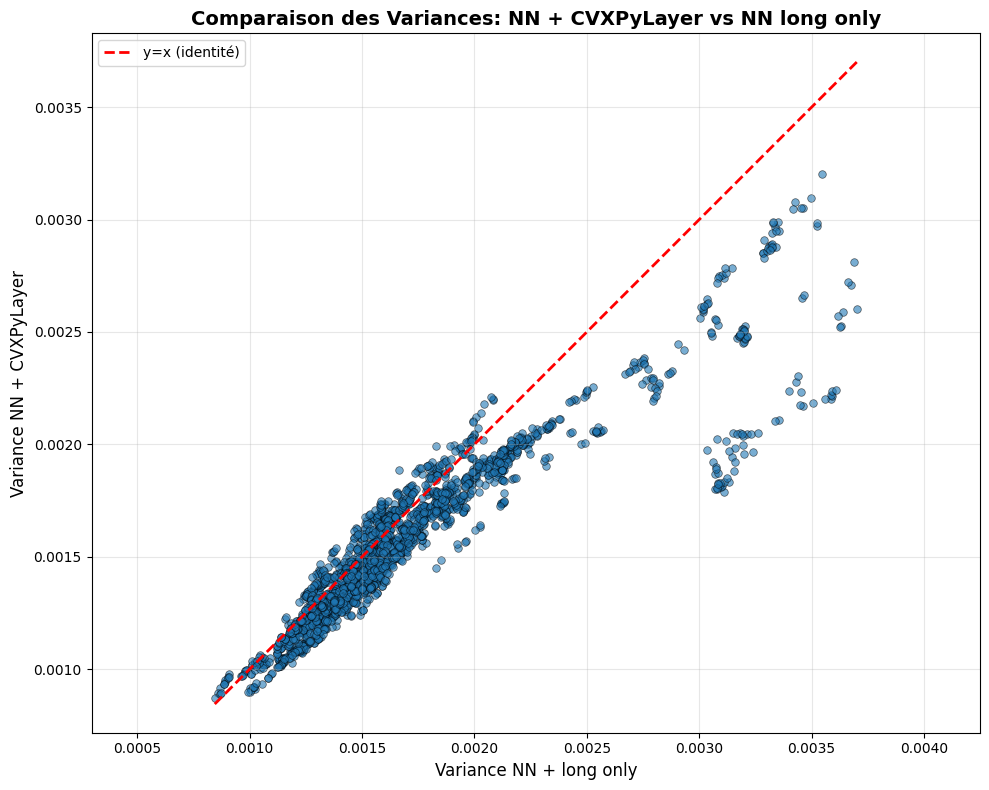

Nombre de points: 2241
Corrélation: 0.9201
Points sous la droite (NN + CVXPyLayer < NN long only): 1751
Points sur/au-dessus de la droite (NN + CVXPyLayer >= NN long only): 490

Réduction relative de variance moyenne (NN + CVXPyLayer vs NN long only): 7.25%


In [ ]:
# VISUALISATION COMPARATIVE DES VARIANCES

# Créer le graphique
plt.figure(figsize=(10, 8))

# Nuage de points : NN seul (x-axis) vs NN + CVXPyLayer (y-axis)
plt.scatter(NN_lo_std, NN_cvxpylayer_std, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Ajouter la droite y=x (identité)
min_val = min(NN_lo_std.min(), NN_cvxpylayer_std.min())
max_val = max(NN_lo_std.max(), NN_cvxpylayer_std.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (identité)')

# Titres et labels
plt.xlabel('Variance NN + long only', fontsize=12)
plt.ylabel('Variance NN + CVXPyLayer', fontsize=12)
plt.title('Comparaison des Variances: NN + CVXPyLayer vs NN long only', fontsize=14, fontweight='bold')

# Grille et légende
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Aspect égal pour mieux voir la relation avec y=x
plt.axis('equal')

# Afficher le graphique
plt.tight_layout()
plt.show()

# Statistiques supplémentaires
print(f"Nombre de points: {len(NN_lo_std)}")
print(f"Corrélation: {np.corrcoef(NN_lo_std, NN_cvxpylayer_std)[0,1]:.4f}")
print(f"Points sous la droite (NN + CVXPyLayer < NN long only): {np.sum(NN_cvxpylayer_std < NN_lo_std)}")
print(f"Points sur/au-dessus de la droite (NN + CVXPyLayer >= NN long only): {np.sum(NN_cvxpylayer_std >= NN_lo_std)}")

# Réduction relative de variance
reduction = ((np.mean(NN_lo_std) - np.mean(NN_cvxpylayer_std)) / np.mean(NN_lo_std)) * 100
print(f"\nRéduction relative de variance moyenne (NN + CVXPyLayer vs NN long only): {reduction:.2f}%")

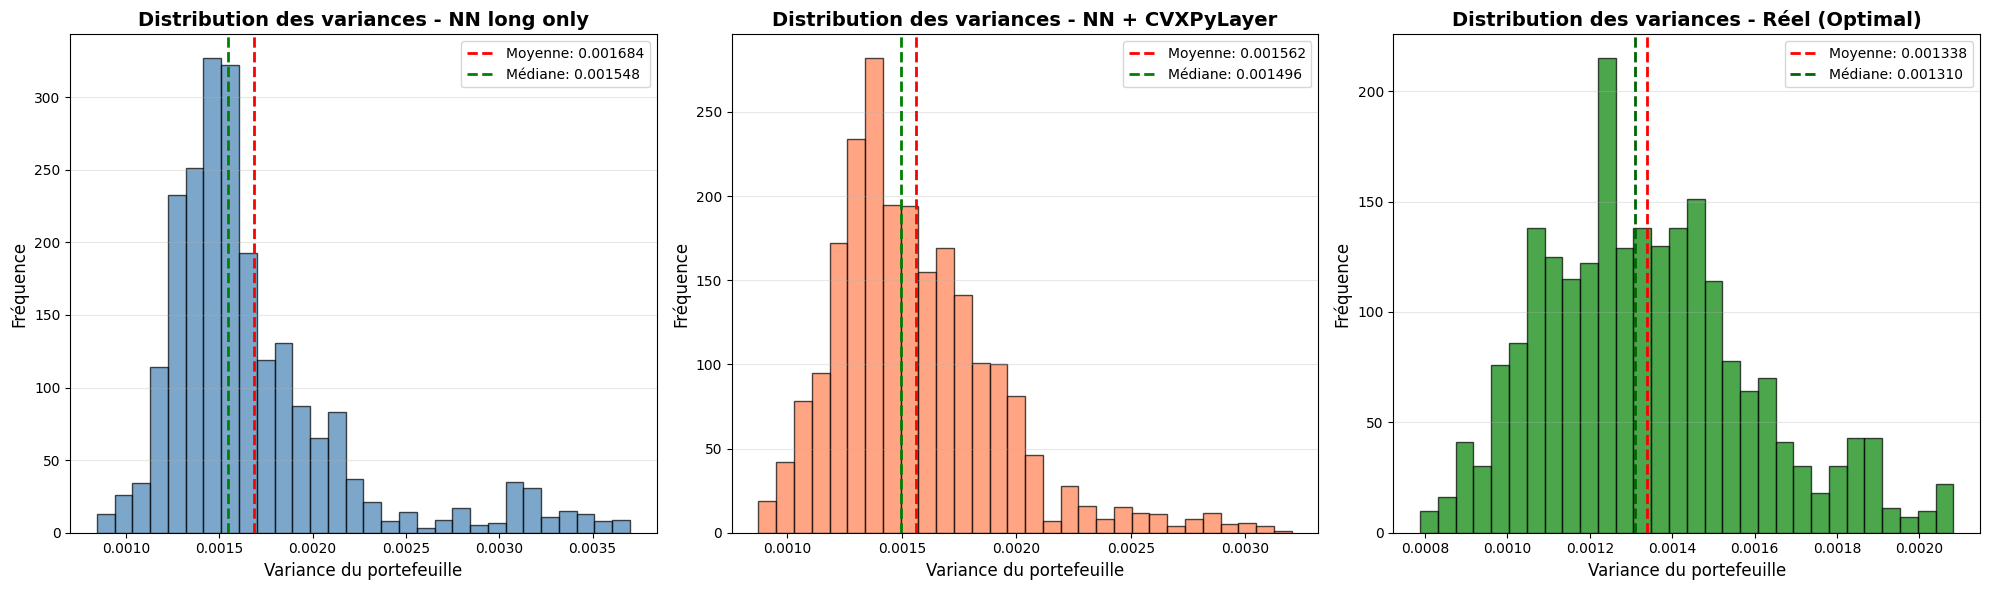

=== Statistiques NN long only ===
Moyenne des variances: 0.00168415
Médiane des variances: 0.00154802
Écart-type: 0.00038712
Min: 0.00084457, Max: 0.00370081

=== Statistiques NN + CVXPyLayer ===
Moyenne des variances: 0.00156214
Médiane des variances: 0.00149610
Écart-type: 0.00036488
Min: 0.00087353, Max: 0.00320263

=== Statistiques Réel (Optimal) ===
Moyenne des variances: 0.00133820
Médiane des variances: 0.00130961
Écart-type: 0.00025595
Min: 0.00078808, Max: 0.00208281

=== Comparaisons ===
Nombre de fois où NN long only < NN + CVXPyLayer: 490/2241 (21.9%)
Nombre de fois où NN + CVXPyLayer < NN seul: 1751/2241 (78.1%)
Nombre de fois où NN long only < Optimal: 0/2241
Nombre de fois où NN + CVXPyLayer < Optimal: 0/2241

=== Réduction de Variance ===
Réduction moyenne NN + CVXPyLayer vs NN long only: 7.25%
Réduction médiane NN + CVXPyLayer vs NN long only: 3.35%


In [ ]:
# VISUALISATION DES DISTRIBUTIONS DE VARIANCE

# Créer une figure avec trois sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Premier histogramme : NN seul
ax1.hist(NN_lo_std, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Variance du portefeuille', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution des variances - NN long only', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

mean_NN_lo = np.mean(NN_lo_std)
median_NN_lo = np.median(NN_lo_std)
ax1.axvline(mean_NN_lo, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_NN_lo:.6f}')
ax1.axvline(median_NN_lo, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_NN_lo:.6f}')
ax1.legend(fontsize=10)

# Deuxième histogramme : NN + CVXPyLayer (long-only)
ax2.hist(NN_cvxpylayer_std, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Variance du portefeuille', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution des variances - NN + CVXPyLayer', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

mean_cvxpy = np.mean(NN_cvxpylayer_std)
median_cvxpy = np.median(NN_cvxpylayer_std)
ax2.axvline(mean_cvxpy, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_cvxpy:.6f}')
ax2.axvline(median_cvxpy, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_cvxpy:.6f}')
ax2.legend(fontsize=10)

# Troisième histogramme : Réel (optimal)
ax3.hist(real_std, bins=30, color='green', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Variance du portefeuille', fontsize=12)
ax3.set_ylabel('Fréquence', fontsize=12)
ax3.set_title('Distribution des variances - Réel (Optimal)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

mean_real = np.mean(real_std)
median_real = np.median(real_std)
ax3.axvline(mean_real, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_real:.6f}')
ax3.axvline(median_real, color='darkgreen', linestyle='--', linewidth=2, label=f'Médiane: {median_real:.6f}')
ax3.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Afficher les statistiques
print("=== Statistiques NN long only ===")
print(f"Moyenne des variances: {mean_NN_lo:.8f}")
print(f"Médiane des variances: {median_NN_lo:.8f}")
print(f"Écart-type: {np.std(NN_std):.8f}")
print(f"Min: {np.min(NN_lo_std):.8f}, Max: {np.max(NN_lo_std):.8f}")

print("\n=== Statistiques NN + CVXPyLayer ===")
print(f"Moyenne des variances: {mean_cvxpy:.8f}")
print(f"Médiane des variances: {median_cvxpy:.8f}")
print(f"Écart-type: {np.std(NN_cvxpylayer_std):.8f}")
print(f"Min: {np.min(NN_cvxpylayer_std):.8f}, Max: {np.max(NN_cvxpylayer_std):.8f}")

print("\n=== Statistiques Réel (Optimal) ===")
print(f"Moyenne des variances: {mean_real:.8f}")
print(f"Médiane des variances: {median_real:.8f}")
print(f"Écart-type: {np.std(real_std):.8f}")
print(f"Min: {np.min(real_std):.8f}, Max: {np.max(real_std):.8f}")

print("\n=== Comparaisons ===")
print(f"Nombre de fois où NN long only < NN + CVXPyLayer: {np.sum(NN_lo_std < NN_cvxpylayer_std)}/{len(NN_lo_std)} ({100*np.sum(NN_lo_std < NN_cvxpylayer_std)/len(NN_lo_std):.1f}%)")
print(f"Nombre de fois où NN + CVXPyLayer < NN seul: {np.sum(NN_cvxpylayer_std < NN_lo_std)}/{len(NN_lo_std)} ({100*np.sum(NN_cvxpylayer_std < NN_lo_std)/len(NN_lo_std):.1f}%)")
print(f"Nombre de fois où NN long only < Optimal: {np.sum(NN_lo_std < real_std)}/{len(NN_lo_std)}")
print(f"Nombre de fois où NN + CVXPyLayer < Optimal: {np.sum(NN_cvxpylayer_std < real_std)}/{len(NN_lo_std)}")

print("\n=== Réduction de Variance ===")

# Réduction de variance moyenne (NN + CVXPyLayer vs NN long only)
reduction_mean = ((mean_NN_lo - mean_cvxpy) / mean_NN_lo) * 100
print(f"Réduction moyenne NN + CVXPyLayer vs NN long only: {reduction_mean:.2f}%")

# Réduction de variance médiane
reduction_median = ((median_NN_lo - median_cvxpy) / median_NN_lo) * 100
print(f"Réduction médiane NN + CVXPyLayer vs NN long only: {reduction_median:.2f}%")


### NN_cvxpylayer vs NN 

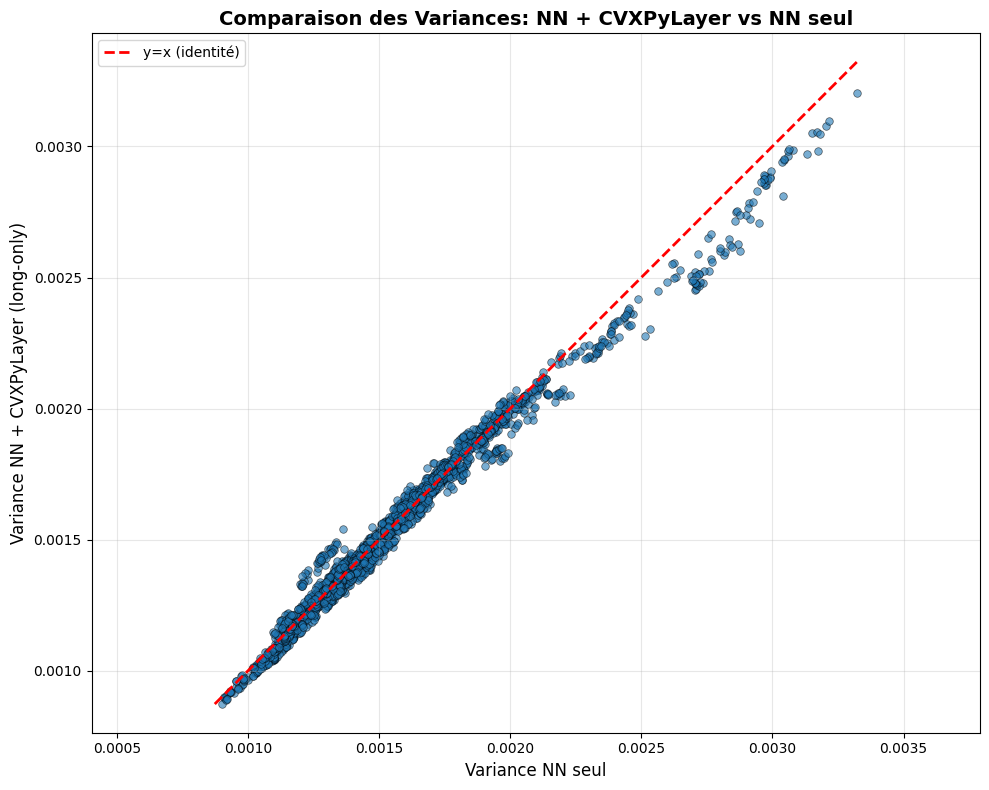

Nombre de points: 2241
Corrélation: 0.9923
Points sous la droite (NN + CVXPyLayer < NN seul): 1272
Points sur/au-dessus de la droite (NN + CVXPyLayer >= NN seul): 969


Réduction de variance moyenne (NN + CVXPyLayer vs NN seul): 0.53%


In [ ]:
# VISUALISATION COMPARATIVE DES VARIANCES

# Créer le graphique
plt.figure(figsize=(10, 8))

# Nuage de points : NN seul (x-axis) vs NN + CVXPyLayer (y-axis)
plt.scatter(NN_std, NN_cvxpylayer_std, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Ajouter la droite y=x (identité)
min_val = min(NN_std.min(), NN_cvxpylayer_std.min())
max_val = max(NN_std.max(), NN_cvxpylayer_std.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (identité)')

# Titres et labels
plt.xlabel('Variance NN seul', fontsize=12)
plt.ylabel('Variance NN + CVXPyLayer (long-only)', fontsize=12)
plt.title('Comparaison des Variances: NN + CVXPyLayer vs NN seul', fontsize=14, fontweight='bold')

# Grille et légende
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Aspect égal pour mieux voir la relation avec y=x
plt.axis('equal')

# Afficher le graphique
plt.tight_layout()
plt.show()

# Statistiques supplémentaires
print(f"Nombre de points: {len(NN_std)}")
print(f"Corrélation: {np.corrcoef(NN_std, NN_cvxpylayer_std)[0,1]:.4f}")
print(f"Points sous la droite (NN + CVXPyLayer < NN seul): {np.sum(NN_cvxpylayer_std < NN_std)}")
print(f"Points sur/au-dessus de la droite (NN + CVXPyLayer >= NN seul): {np.sum(NN_cvxpylayer_std >= NN_std)}")
print()

# Réduction de variance
reduction = ((np.mean(NN_std) - np.mean(NN_cvxpylayer_std)) / np.mean(NN_std)) * 100
print(f"\nRéduction de variance moyenne (NN + CVXPyLayer vs NN seul): {reduction:.2f}%")


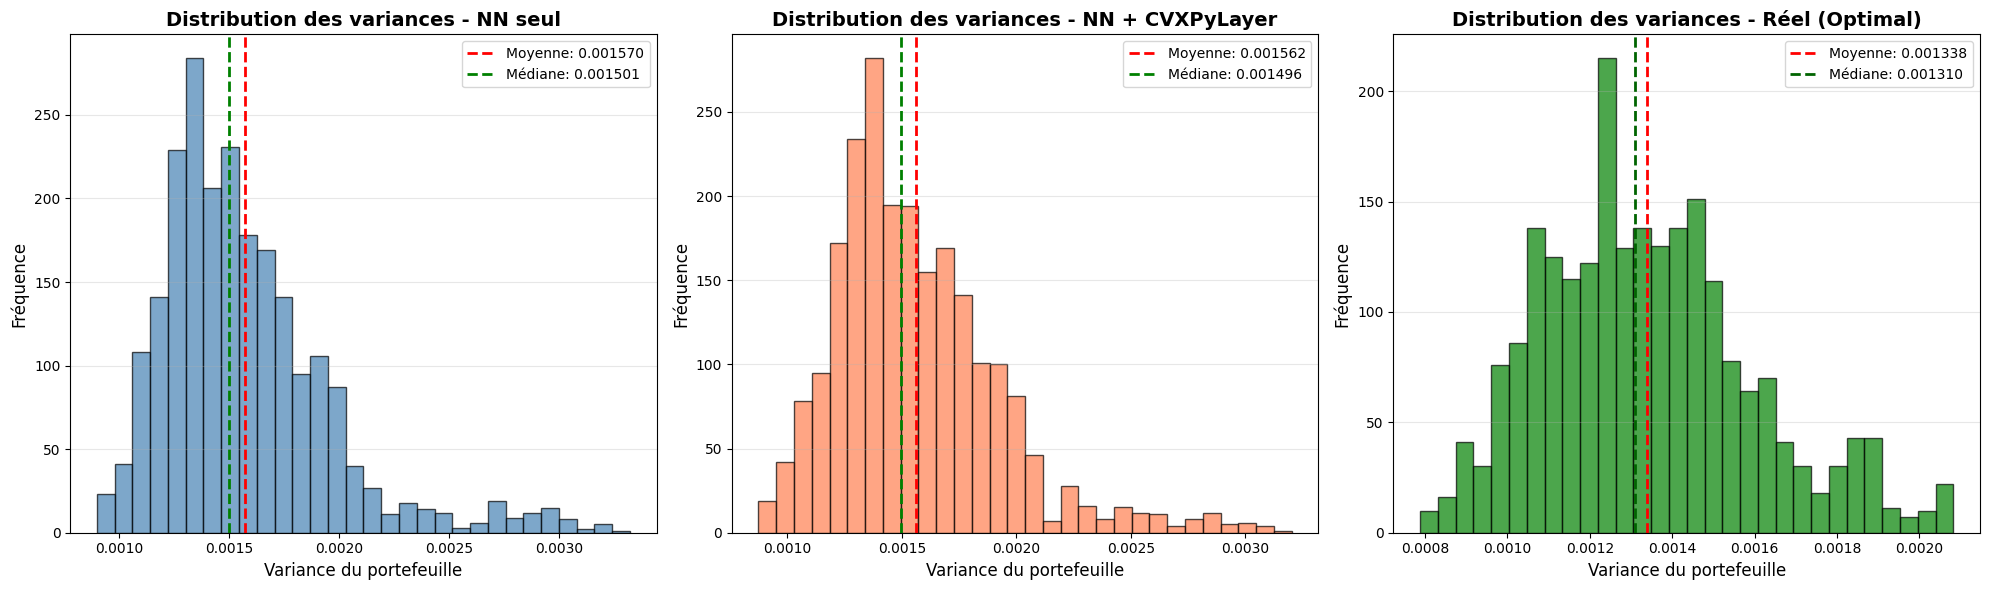

=== Statistiques NN seul ===
Moyenne des variances: 0.00157045
Médiane des variances: 0.00150145
Écart-type: 0.00038712
Min: 0.00089932, Max: 0.00332175

=== Statistiques NN + CVXPyLayer ===
Moyenne des variances: 0.00156214
Médiane des variances: 0.00149610
Écart-type: 0.00036488
Min: 0.00087353, Max: 0.00320263

=== Statistiques Réel (Optimal) ===
Moyenne des variances: 0.00133820
Médiane des variances: 0.00130961
Écart-type: 0.00025595
Min: 0.00078808, Max: 0.00208281

=== Comparaisons ===
Nombre de fois où NN seul < NN + CVXPyLayer: 969/2241 (43.2%)
Nombre de fois où NN + CVXPyLayer < NN seul: 1272/2241 (56.8%)
Nombre de fois où NN seul < Optimal: 0/2241
Nombre de fois où NN + CVXPyLayer < Optimal: 0/2241

=== Réduction de Variance ===
Réduction moyenne NN + CVXPyLayer vs NN seul: 0.53%
Réduction médiane NN + CVXPyLayer vs NN seul: 0.36%


In [ ]:
# VISUALISATION DES DISTRIBUTIONS DE VARIANCE

# Créer une figure avec trois sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Premier histogramme : NN seul
ax1.hist(NN_std, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Variance du portefeuille', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution des variances - NN seul', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

mean_NN = np.mean(NN_std)
median_NN = np.median(NN_std)
ax1.axvline(mean_NN, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_NN:.6f}')
ax1.axvline(median_NN, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_NN:.6f}')
ax1.legend(fontsize=10)

# Deuxième histogramme : NN + CVXPyLayer (long-only)
ax2.hist(NN_cvxpylayer_std, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Variance du portefeuille', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution des variances - NN + CVXPyLayer', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

mean_cvxpy = np.mean(NN_cvxpylayer_std)
median_cvxpy = np.median(NN_cvxpylayer_std)
ax2.axvline(mean_cvxpy, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_cvxpy:.6f}')
ax2.axvline(median_cvxpy, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_cvxpy:.6f}')
ax2.legend(fontsize=10)

# Troisième histogramme : Réel (optimal)
ax3.hist(real_std, bins=30, color='green', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Variance du portefeuille', fontsize=12)
ax3.set_ylabel('Fréquence', fontsize=12)
ax3.set_title('Distribution des variances - Réel (Optimal)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

mean_real = np.mean(real_std)
median_real = np.median(real_std)
ax3.axvline(mean_real, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_real:.6f}')
ax3.axvline(median_real, color='darkgreen', linestyle='--', linewidth=2, label=f'Médiane: {median_real:.6f}')
ax3.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Afficher les statistiques
print("=== Statistiques NN seul ===")
print(f"Moyenne des variances: {mean_NN:.8f}")
print(f"Médiane des variances: {median_NN:.8f}")
print(f"Écart-type: {np.std(NN_std):.8f}")
print(f"Min: {np.min(NN_std):.8f}, Max: {np.max(NN_std):.8f}")

print("\n=== Statistiques NN + CVXPyLayer ===")
print(f"Moyenne des variances: {mean_cvxpy:.8f}")
print(f"Médiane des variances: {median_cvxpy:.8f}")
print(f"Écart-type: {np.std(NN_cvxpylayer_std):.8f}")
print(f"Min: {np.min(NN_cvxpylayer_std):.8f}, Max: {np.max(NN_cvxpylayer_std):.8f}")

print("\n=== Statistiques Réel (Optimal) ===")
print(f"Moyenne des variances: {mean_real:.8f}")
print(f"Médiane des variances: {median_real:.8f}")
print(f"Écart-type: {np.std(real_std):.8f}")
print(f"Min: {np.min(real_std):.8f}, Max: {np.max(real_std):.8f}")

print("\n=== Comparaisons ===")
print(f"Nombre de fois où NN seul < NN + CVXPyLayer: {np.sum(NN_std < NN_cvxpylayer_std)}/{len(NN_std)} ({100*np.sum(NN_std < NN_cvxpylayer_std)/len(NN_std):.1f}%)")
print(f"Nombre de fois où NN + CVXPyLayer < NN seul: {np.sum(NN_cvxpylayer_std < NN_std)}/{len(NN_std)} ({100*np.sum(NN_cvxpylayer_std < NN_std)/len(NN_std):.1f}%)")
print(f"Nombre de fois où NN seul < Optimal: {np.sum(NN_std < real_std)}/{len(NN_std)}")
print(f"Nombre de fois où NN + CVXPyLayer < Optimal: {np.sum(NN_cvxpylayer_std < real_std)}/{len(NN_std)}")

print("\n=== Réduction de Variance ===")

# Réduction de variance moyenne (NN + CVXPyLayer vs NN seul)
reduction_mean = ((mean_NN - mean_cvxpy) / mean_NN) * 100
print(f"Réduction moyenne NN + CVXPyLayer vs NN seul: {reduction_mean:.2f}%")

# Réduction de variance médiane
reduction_median = ((median_NN - median_cvxpy) / median_NN) * 100
print(f"Réduction médiane NN + CVXPyLayer vs NN seul: {reduction_median:.2f}%")


### NN_cvxpylayer vs Sample

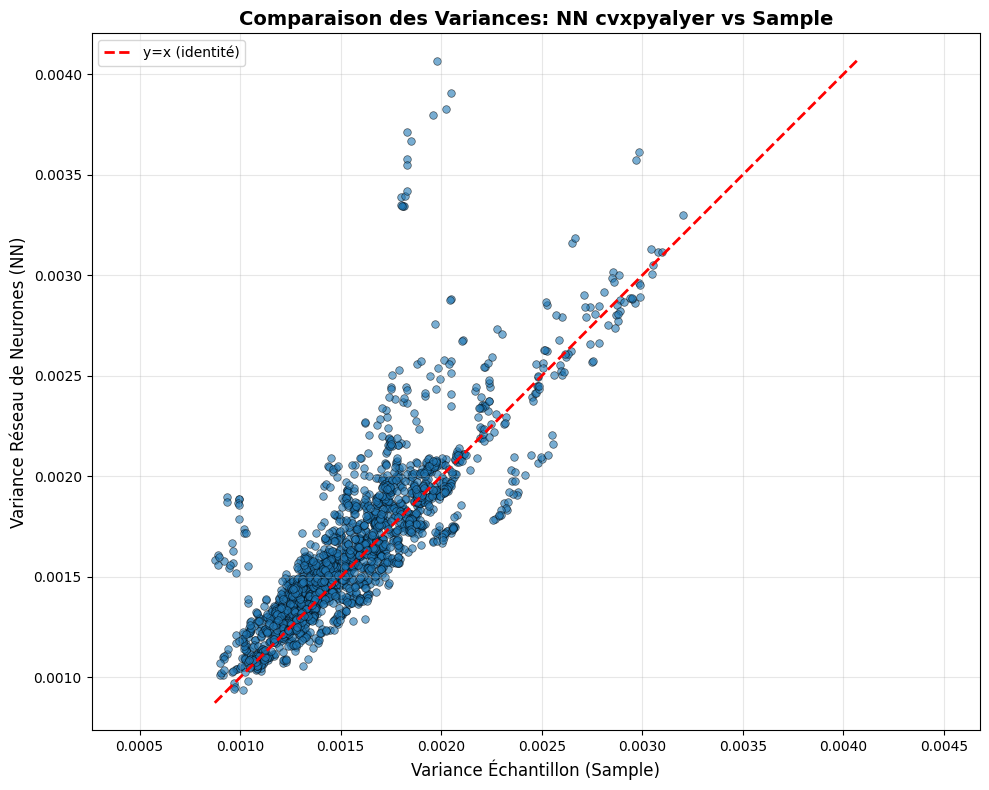

Nombre de points: 2241
Corrélation: 0.8387
Points sous la droite (NN < Sample): 1510
Points sur/au-dessus de la droite (NN >= Sample): 731


In [ ]:
## VISUALISATION COMPARATIVE DES VARIANCES

# Créer le graphique
plt.figure(figsize=(10, 8))

# Nuage de points
plt.scatter(NN_cvxpylayer_std, sample_std, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Ajouter la droite y=x (identité)
min_val = min(sample_std.min(), NN_cvxpylayer_std.min())
max_val = max(sample_std.max(), NN_cvxpylayer_std.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (identité)')

# Titres et labels
plt.xlabel('Variance Échantillon (Sample)', fontsize=12)
plt.ylabel('Variance Réseau de Neurones (NN)', fontsize=12)
plt.title('Comparaison des Variances: NN cvxpyalyer vs Sample', fontsize=14, fontweight='bold')

# Grille et légende
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Aspect égal pour mieux voir la relation avec y=x
plt.axis('equal')

# Afficher le graphique
plt.tight_layout()
plt.show()

# Statistiques supplémentaires
print(f"Nombre de points: {len(sample_std)}")
print(f"Corrélation: {np.corrcoef(sample_std, NN_cvxpylayer_std)[0,1]:.4f}")
print(f"Points sous la droite (NN < Sample): {np.sum(NN_cvxpylayer_std < sample_std)}")
print(f"Points sur/au-dessus de la droite (NN >= Sample): {np.sum(NN_cvxpylayer_std >= sample_std)}")

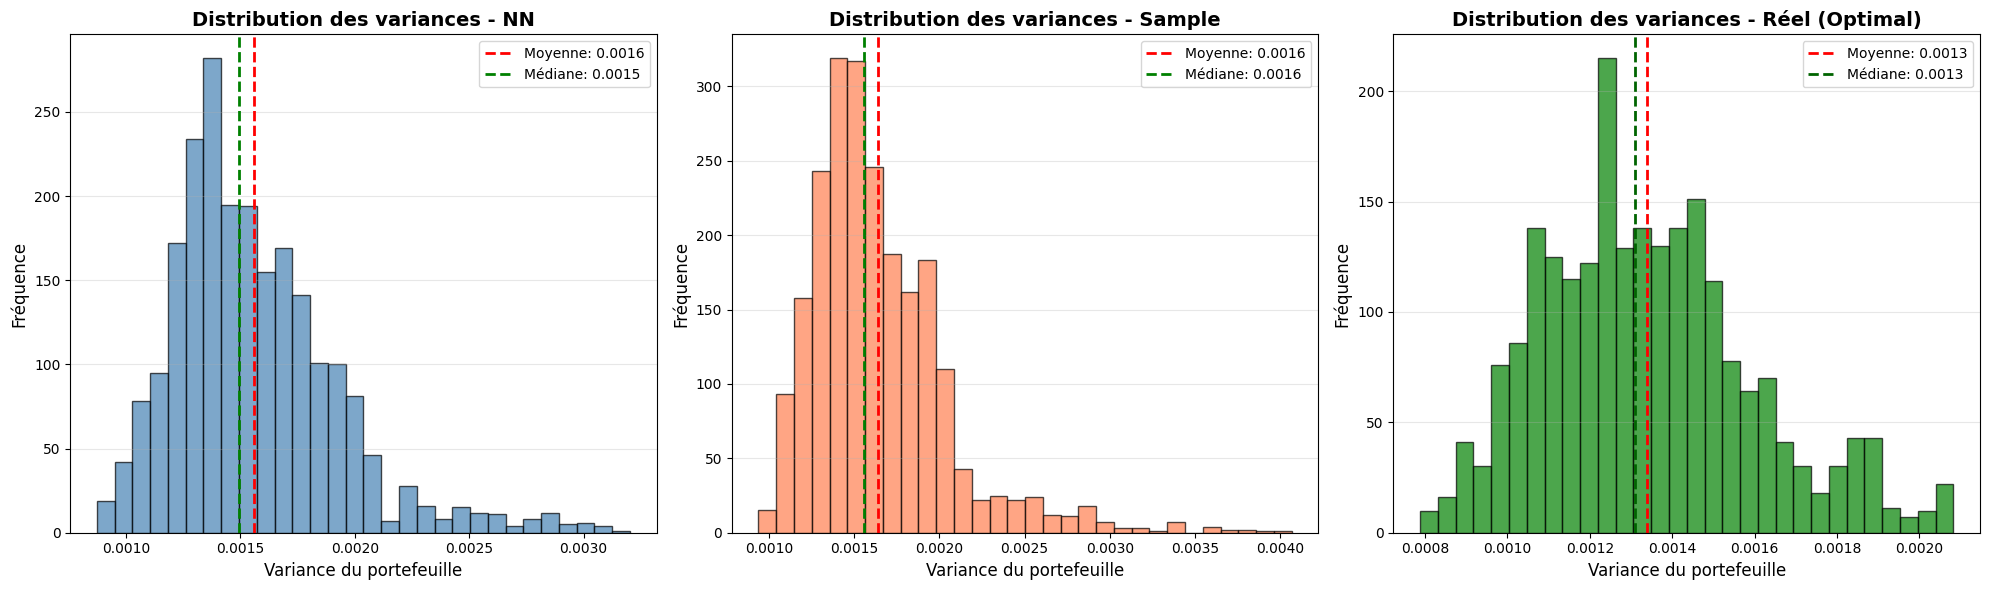

=== Statistiques NN ===
Moyenne des variances: 0.001562
Médiane des variances: 0.001496
Écart-type: 0.000365
Min: 0.000874, Max: 0.003203

=== Statistiques Sample ===
Moyenne des variances: 0.001640
Médiane des variances: 0.001558
Écart-type: 0.000404
Min: 0.000939, Max: 0.004067

=== Statistiques Réel (Optimal) ===
Moyenne des variances: 0.001338
Médiane des variances: 0.001310
Écart-type: 0.000256
Min: 0.000788, Max: 0.002083

=== Comparaisons ===
Nombre de fois où NN < Sample: 1510/2241
Nombre de fois où NN < Optimal: 0/2241
Nombre de fois où Sample < Optimal: 0/2241

=== Réduction de Variance ===
Réduction moyenne NN vs Sample: 4.76%
Réduction médiane NN vs Sample: 3.99%


In [ ]:
# VISUALISATION DES DISTRIBUTIONS DE VARIANCE

# Créer une figure avec trois sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Premier histogramme : NN
ax1.hist(NN_cvxpylayer_std, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Variance du portefeuille', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution des variances - NN', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

mean_NN_cvxpylayer = np.mean(NN_cvxpylayer_std)
median_NN_cvxpylayer = np.median(NN_cvxpylayer_std)
ax1.axvline(mean_NN_cvxpylayer, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_NN_cvxpylayer:.4f}')
ax1.axvline(median_NN_cvxpylayer, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_NN_cvxpylayer:.4f}')
ax1.legend(fontsize=10)

# Deuxième histogramme : Sample
ax2.hist(sample_std, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Variance du portefeuille', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution des variances - Sample', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

mean_sample = np.mean(sample_std)
median_sample = np.median(sample_std)
ax2.axvline(mean_sample, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_sample:.4f}')
ax2.axvline(median_sample, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_sample:.4f}')
ax2.legend(fontsize=10)

# Troisième histogramme : Réel (optimal)
ax3.hist(real_std, bins=30, color='green', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Variance du portefeuille', fontsize=12)
ax3.set_ylabel('Fréquence', fontsize=12)
ax3.set_title('Distribution des variances - Réel (Optimal)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

mean_real = np.mean(real_std)
median_real = np.median(real_std)
ax3.axvline(mean_real, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_real:.4f}')
ax3.axvline(median_real, color='darkgreen', linestyle='--', linewidth=2, label=f'Médiane: {median_real:.4f}')
ax3.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Afficher les statistiques
print("=== Statistiques NN ===")
print(f"Moyenne des variances: {mean_NN_cvxpylayer:.6f}")
print(f"Médiane des variances: {median_NN_cvxpylayer:.6f}")
print(f"Écart-type: {np.std(NN_cvxpylayer_std):.6f}")
print(f"Min: {np.min(NN_cvxpylayer_std):.6f}, Max: {np.max(NN_cvxpylayer_std):.6f}")

print("\n=== Statistiques Sample ===")
print(f"Moyenne des variances: {mean_sample:.6f}")
print(f"Médiane des variances: {median_sample:.6f}")
print(f"Écart-type: {np.std(sample_std):.6f}")
print(f"Min: {np.min(sample_std):.6f}, Max: {np.max(sample_std):.6f}")

print("\n=== Statistiques Réel (Optimal) ===")
print(f"Moyenne des variances: {mean_real:.6f}")
print(f"Médiane des variances: {median_real:.6f}")
print(f"Écart-type: {np.std(real_std):.6f}")
print(f"Min: {np.min(real_std):.6f}, Max: {np.max(real_std):.6f}")

print("\n=== Comparaisons ===")
print(f"Nombre de fois où NN < Sample: {np.sum(NN_cvxpylayer_std < sample_std)}/{len(NN_cvxpylayer_std)}")
print(f"Nombre de fois où NN < Optimal: {np.sum(NN_cvxpylayer_std < real_std)}/{len(NN_cvxpylayer_std)}")
print(f"Nombre de fois où Sample < Optimal: {np.sum(sample_std < real_std)}/{len(sample_std)}")

print("\n=== Réduction de Variance ===")

# Réduction de variance moyenne (NN vs Sample)
reduction_mean = ((mean_sample - mean_NN_cvxpylayer) / mean_sample) * 100
print(f"Réduction moyenne NN vs Sample: {reduction_mean:.2f}%")

# Réduction de variance médiane (NN vs Sample)
reduction_median = ((median_sample - median_NN_cvxpylayer) / median_sample) * 100
print(f"Réduction médiane NN vs Sample: {reduction_median:.2f}%")
